In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.geometry import Point

from tile_units import TileUnit
from tile_units import TileShape
from tile_map import Tiling

In [2]:
ak = geopandas.read_file("../data/imd-auckland-2018.gpkg")

# H3 tiles
Note really H3 per se, but a rescaling of the regular hex tiling suitably rotated and with the tiles further rescaled so they have a margin around them that makes it possible to 'indexically' determine which is which.

In [3]:
d = 600
tile_unit = TileUnit(spacing = d, crs = 2193, tile_shape = TileShape.HEXAGON)

In [4]:
# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

# inset scaling
sf2 = 0.9

hex = scale(tile_unit.tile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners]
hexes = geopandas.GeoSeries(hexes, crs = ak.crs).rotate(
    rotation, origin = (0, 0)).scale(sf2, sf2, origin = (0, 0))

<AxesSubplot:>

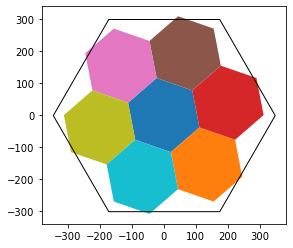

In [5]:
tile_unit.elements = geopandas.GeoDataFrame(
    data = {"element_id": list("abcdefg")}, crs = ak.crs,
    geometry = hexes
)
ax = tile_unit.elements.plot(column = "element_id")
tile_unit.tile.plot(ax = ax, edgecolor = "k", facecolor = "#00000000")

In [6]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
t30 = tiling.get_tiled_map(prioritise_tiles = True)

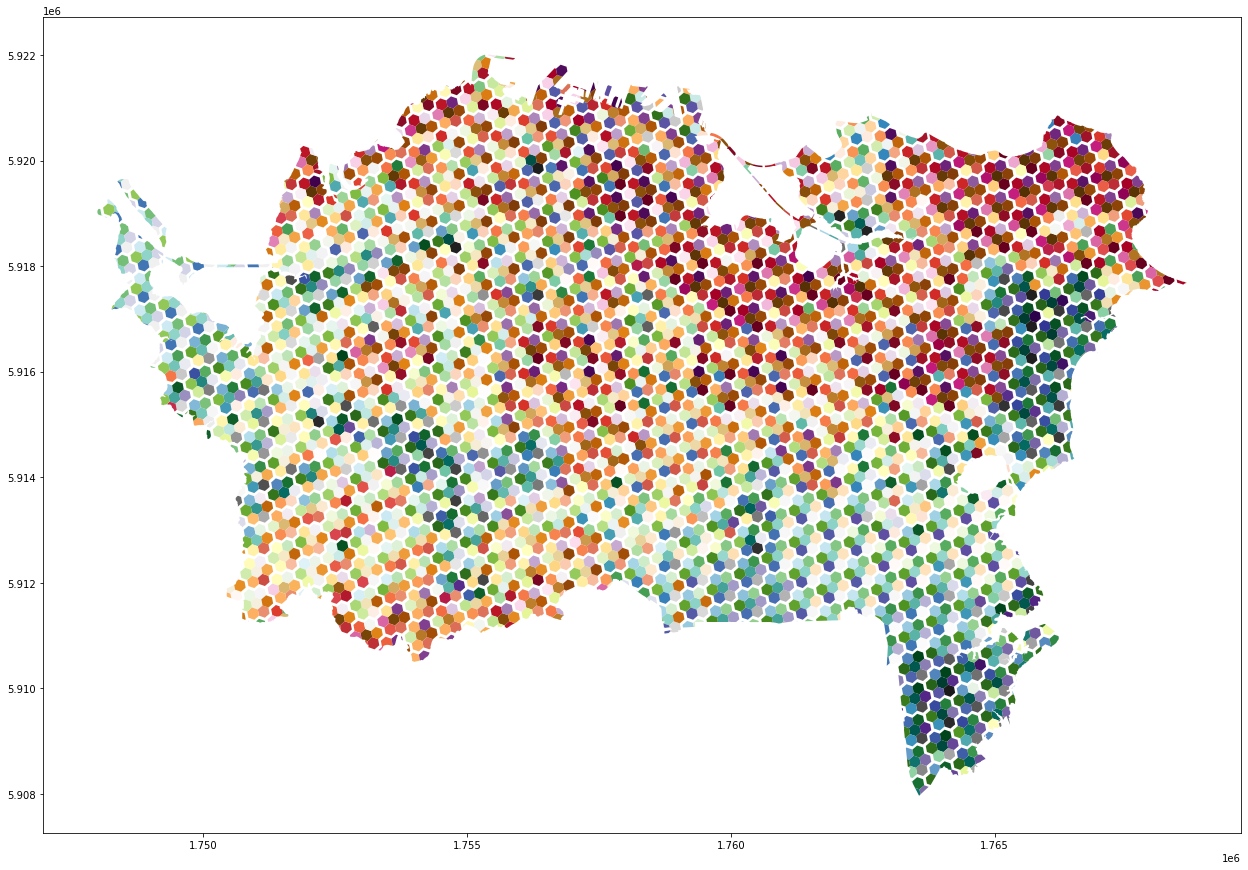

In [7]:
fig = pyplot.figure(figsize = (24, 15))
ax = fig.add_subplot(111)

strands = set(t30.element_id)
cols = [x for x in t30.columns if "Rank" in x]
cmaps = ("BrBG", "RdGy", "RdYlBu", "Spectral",
         "PiYG", "PRGn", "PuOr", "viridis")

for strand, col, cmap in zip(strands, cols, cmaps):
    t30[t30.element_id == strand].plot(ax = ax, column = col, cmap = cmap)

It seems likely a reader could cope with the 7 hexes shown.

## More 'levels'
We can apply a similar logic to make other rescaled hex tilings that are subdivisible into sets of tiles that are themselves 'super-hexes'. Much beyond one more level seems a stretch, but in principle many other levels are available.

<AxesSubplot:>

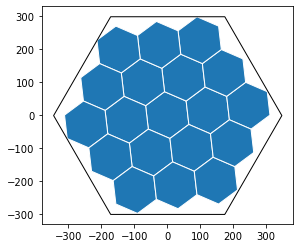

In [8]:
level = 2
ns = [1, 7, 19, 37, 61, 91]
sfs = [1 / np.sqrt(_) for _ in ns]
sf = sfs[level]

hex = tile_unit.tile.geometry[0]
hex = scale(rotate(hex, 90), sf, sf)
hexes = [hex]

# vectors to displace hexes to position on a 'dissected' hex tiling
v1 = Point([d * sf, 0])
v2 = Point([d * sf * np.cos(np.pi * 2 / 3), 
            d * sf * np.sin(np.pi * 2 / 3)])

# iterate over levels
for i in range(1, level + 1):
    # each level needs #level additional hexes on each 'side'
    vs = [(i * v1.x + j * v2.x, i * v1.y + j * v2.y) 
               for j in range(i)]
    # rotated 6 times
    extra_hexes = [translate(hex, v[0], v[1]) for v in vs]
    for rot in [_ * 60  for _ in range(6)]:
        hexes.extend([rotate(h, rot, origin = (0, 0)) for h in extra_hexes])

# Rotation angle to align with the original hex tile
rotation = (0 
            if level == 0
            else np.degrees(np.arctan(1 / (level * 2 + 1) / np.sqrt(3))))

# inset scale factor
sf2 = 0.9
hexes = geopandas.GeoSeries(hexes).rotate(
    rotation, origin = (0, 0)).scale(sf2, sf2, origin = (0, 0))  

ax = hexes.plot(edgecolor = "w")
tile_unit.tile.plot(ax = ax, facecolor = "#00000000", edgecolor = "k")


And subsets could be picked out as tile elements. Here just every other sub-hex, for example: 

<AxesSubplot:>

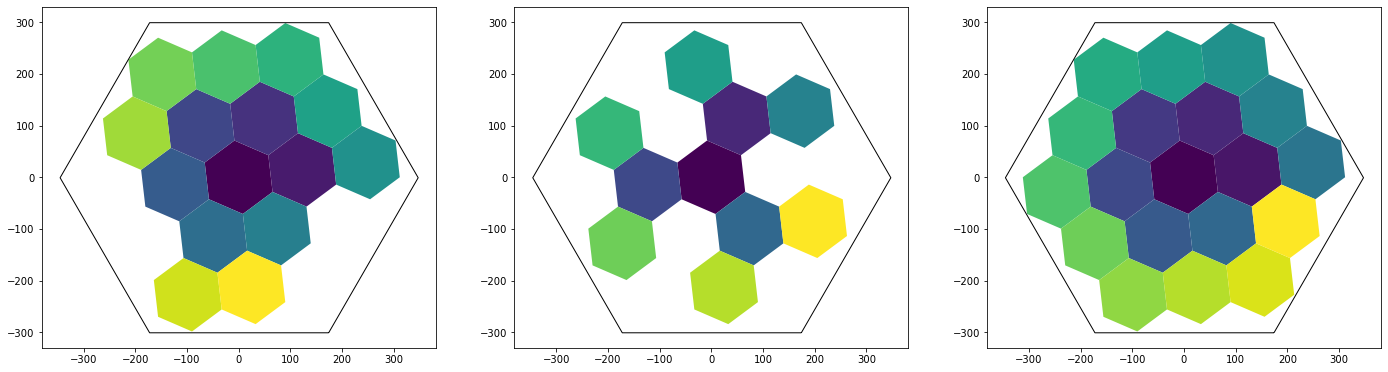

In [9]:

# some element_id labels
import string
labels = string.printable

import random
selector1 = random.choices([True, False], k = len(hexes))
selector2 = (100 * [True, False])[:len(hexes)]
selector3 = [True] * len(hexes)

unit1 = geopandas.GeoDataFrame(
    data = {"element_id": list(labels)[:len(hexes)]},
    geometry = hexes, crs = ak.crs
)[selector1]

unit2 = geopandas.GeoDataFrame(
    data = {"element_id": list(labels)[:len(hexes)]},
    geometry = hexes, crs = ak.crs
)[selector2]

unit3 = geopandas.GeoDataFrame(
    data = {"element_id": list(labels)[:len(hexes)]},
    geometry = hexes, crs = ak.crs
)[selector3]

fig = pyplot.figure(figsize = (24, 8))
ax = fig.add_subplot(131)
unit1.plot(ax = ax, column = "element_id", cmap = "viridis")
tile_unit.tile.plot(ax = ax, facecolor = "#00000000", edgecolor = "k")

ax = fig.add_subplot(132)
unit2.plot(ax = ax, column = "element_id", cmap = "viridis")
tile_unit.tile.plot(ax = ax, facecolor = "#00000000", edgecolor = "k")

ax = fig.add_subplot(133)
unit3.plot(ax = ax, column = "element_id", cmap = "viridis")
tile_unit.tile.plot(ax = ax, facecolor = "#00000000", edgecolor = "k")

<AxesSubplot:>

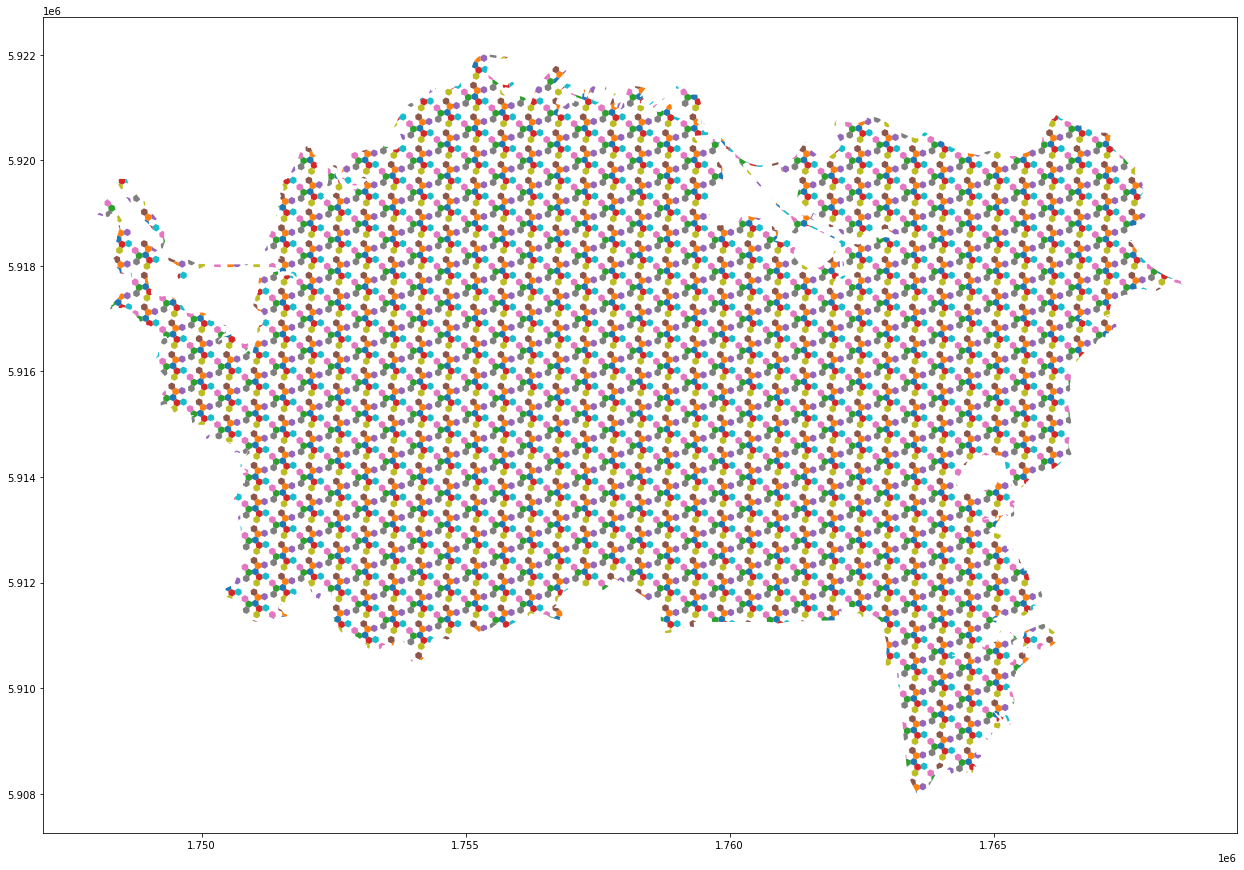

In [10]:
tile_unit.elements = unit2
tiling = Tiling(tile_unit, ak, id_var = "DZ2018")
h3_map = tiling.get_tiled_map(prioritise_tiles = True)
h3_map.plot(column = "element_id", figsize = (24, 15))

## And since these are now glyphs...
Why not place them at zone centroids. Implementing this properly would take a bit or reorganisation of the code.

In [11]:
tiling.tile_unit.elements.geometry = unit2.geometry.scale(0.9, origin = (0, 0))
tiling.tiles = None
tiling.grid.points = ak.centroid.geometry
tiling.tiles = tiling.make_tiling()

<AxesSubplot:>

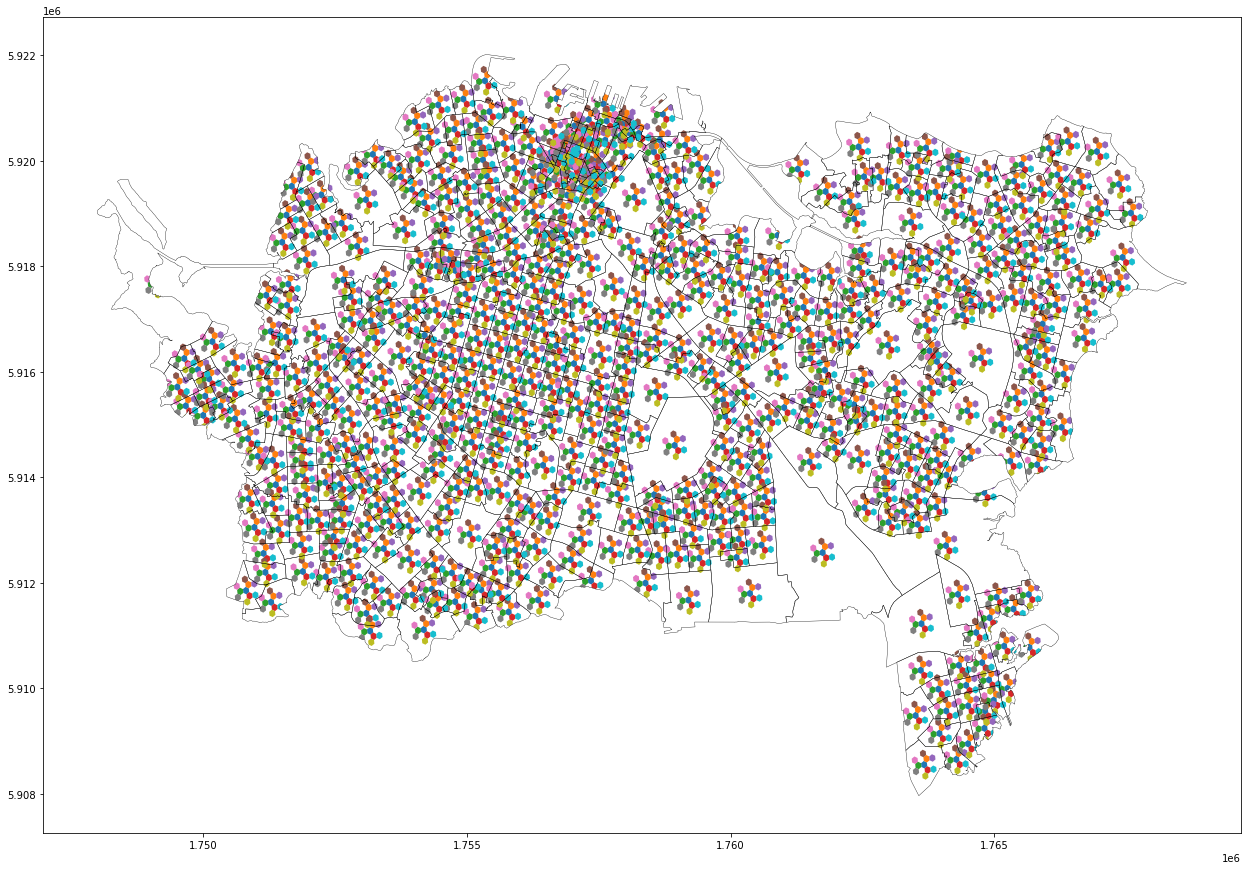

In [12]:
ax = tiling.get_tiled_map(prioritise_tiles = True).plot(
        figsize = (24, 15), column = "element_id", linewidth = 0.0)
ak.plot(ax = ax, facecolor = "#00000000", edgecolor = "k", linewidth = 0.35)